# Problem Statement

[An article in the Dallas Observer](https://www.dallasobserver.com/restaurants/dallas-restaurant-inspections-suffer-from-delays-poor-record-keeping-and-overworked-staff-10697588) unearthed a massive problem in the city's ability to follow up on restaurants requiring reinspection due to a low grade upon original inspection.  Dallas states that out of a scale from 1-100, any facility that scores between 70-79 requires reinspection within 30 days, between 60-69 requires reinspection within 10 days, and below 60 requires reinspection ASAP.

The article points out many flaws in the city's ability to reinspect restaurants within its own self-imposed timeframes,.  Until the department can hopefully become better-staffed, I am looking to build a classification model that can predict how a restaurant will perform upon reinspection.  This way, if the city is still struggling to reinspect restaurants in a timely manner, they can refer to the model in order to prioritize certain facilities to reinspect.



In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.base import TransformerMixin

%matplotlib inline

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


# Data Collection

In [4]:
df = pd.read_csv('./data/Restaurant_and_Food_Establishment_Inspections__October_2016_to_Present_.csv')

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (10,97,103,105,106,107,109,110) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df.head()

,Restaurant Name,Inspection Type,Inspection Date,Inspection Score,Street Number,Street Name,Street Direction,Street Type,Street Unit,Street Address,...,Violation Points - 24,Violation Detail - 24,Violation Memo - 24,Violation Description - 25,Violation Points - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location
0,FRESHII,Routine,10/31/2018,96,2414,VICTORY PARK,NaN,LN,NaN,2414 VICTORY PARK LN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct 2018,FY2019,"2414 VICTORY PARK LN\n(32.787625, -96.809294)"
1,MICKLE CHICKEN,Routine,10/30/2019,100,3203,CAMP WISDOM,W,RD,NaN,3203 W CAMP WISDOM RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct 2019,FY2020,"3203 W CAMP WISDOM RD\n(32.662584, -96.873446)"
2,WORLD TRADE CENTER MARKET,Routine,11/03/2016,100,2050,STEMMONS,N,FRWY,NaN,2050 N STEMMONS FRWY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nov 2016,FY2017,"2050 N STEMMONS FRWY\n(32.801934, -96.825878)"
3,DUNKIN DONUTS,Routine,10/30/2019,99,8008,HERB KELLEHER,NaN,WAY,C2174,8008 HERB KELLEHER WAY STE# C2174,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct 2019,FY2020,8008 HERB KELLEHER WAY STE# C2174
4,CANVAS HOTEL - 6TH FLOOR,Routine,06/11/2018,100,1325,LAMAR,S,ST,NaN,1325 S LAMAR ST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jun 2018,FY2018,"1325 S LAMAR ST\n(39.69335, -105.067425)"


# Data Cleaning

In [6]:
df.shape

(44656, 114)

In [7]:
df.isnull().sum().sort_values(ascending = False).tail()

Street Number        0
Inspection Score     0
Inspection Date      0
Inspection Type      0
Lat Long Location    0
dtype: int64

In [8]:
df.loc[df['Restaurant Name'].isnull()]

,Restaurant Name,Inspection Type,Inspection Date,Inspection Score,Street Number,Street Name,Street Direction,Street Type,Street Unit,Street Address,...,Violation Points - 24,Violation Detail - 24,Violation Memo - 24,Violation Description - 25,Violation Points - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location
20592,NaN,Routine,02/21/2018,86,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Feb 2018,FY2018,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"
21643,NaN,Routine,08/28/2017,87,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aug 2017,FY2017,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"
24064,NaN,Routine,07/28/2017,87,6449,GREENVILLE,NaN,AVE,NaN,6449 GREENVILLE AVE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jul 2017,FY2017,"6449 GREENVILLE AVE\n(32.863098, -96.767426)"
24612,NaN,Routine,08/06/2018,91,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aug 2018,FY2018,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"
26713,NaN,Routine,02/02/2017,88,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Feb 2017,FY2017,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"
33050,NaN,Routine,11/27/2017,80,8686,FERGUSON,NaN,RD,#210,8686 FERGUSON RD #210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nov 2017,FY2018,"8686 FERGUSON RD #210\n(32.812751, -96.698799)"
34370,NaN,Routine,06/13/2018,87,6449,GREENVILLE,NaN,AVE,NaN,6449 GREENVILLE AVE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jun 2018,FY2018,"6449 GREENVILLE AVE\n(32.863098, -96.767426)"
39616,NaN,Routine,05/22/2018,92,8686,FERGUSON,NaN,RD,#210,8686 FERGUSON RD #210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,May 2018,FY2018,"8686 FERGUSON RD #210\n(32.812751, -96.698799)"
43261,NaN,Routine,05/31/2017,91,8686,FERGUSON,NaN,RD,#210,8686 FERGUSON RD #210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,May 2017,FY2017,"8686 FERGUSON RD #210\n(32.812751, -96.698799)"
43934,NaN,Routine,01/03/2018,84,6449,GREENVILLE,NaN,AVE,NaN,6449 GREENVILLE AVE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jan 2018,FY2018,"6449 GREENVILLE AVE\n(32.863098, -96.767426)"


In [9]:
df.loc[df['Street Number'] == 4243].head()

,Restaurant Name,Inspection Type,Inspection Date,Inspection Score,Street Number,Street Name,Street Direction,Street Type,Street Unit,Street Address,...,Violation Points - 24,Violation Detail - 24,Violation Memo - 24,Violation Description - 25,Violation Points - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location
4333,WILLIAMS CHICKEN,Routine,08/14/2019,94,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aug 2019,FY2019,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"
10552,WILLIAMS CHICKEN,Routine,02/12/2020,92,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Feb 2020,FY2020,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"
14015,WILLIAMS CHICKEN,Routine,02/11/2019,97,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Feb 2019,FY2019,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"
20592,NaN,Routine,02/21/2018,86,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Feb 2018,FY2018,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"
21643,NaN,Routine,08/28/2017,87,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aug 2017,FY2017,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"


While the null restaurants seem to line up with an actual restaurant, I could not find evidence that this location was an identical or different restaurant during time of inspection.  Instead of imputing what I assume is the restaurant name, I will impute the name of unkown.

In [10]:
df.dtypes.value_counts()

object     87
float64    25
int64       2
dtype: int64

In [11]:
dtypes_df = pd.DataFrame(df.dtypes)

object_cols = dtypes_df.loc[dtypes_df[0] == 'object'].index

float_cols = dtypes_df.loc[dtypes_df[0] == 'float64'].index



In [12]:
df[object_cols] = df[object_cols].fillna(' ')

In [13]:
df['calculated_score'] = 100 - df[float_cols].sum(axis = 1)

In [14]:
df.loc[df['Inspection Score'] != df['calculated_score']]

,Restaurant Name,Inspection Type,Inspection Date,Inspection Score,Street Number,Street Name,Street Direction,Street Type,Street Unit,Street Address,...,Violation Detail - 24,Violation Memo - 24,Violation Description - 25,Violation Points - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location,calculated_score
20,JERSEY MIKES SUBS,Routine,10/04/2018,89,14060,DALLAS,,PKWY,400,14060 DALLAS PKWY STE 400,...,,,,NaN,,,Oct 2018,FY2019,"14060 DALLAS PKWY STE 400\n(32.938693, -96.821...",100.0
30,CANTINA LAREDO,Routine,10/30/2019,0,6025,ROYAL,,LN,#250,6025 ROYAL LN #250,...,,,,NaN,,,Oct 2019,FY2020,"6025 ROYAL LN #250\n(32.894884, -96.802798)",100.0
83,CIELO CREATIONS,Follow-up,03/27/2019,88,2711,HASKELL,N,AVE,#C3,2711 N HASKELL AVE #C3,...,,,,NaN,,,Mar 2019,FY2019,"2711 N HASKELL AVE #C3\n(32.807044, -96.792783)",100.0
308,PIZZA HUT,Routine,06/12/2019,83,222,CONTINENTAL,,AVE,,222 CONTINENTAL AVE,...,,,,NaN,,,Jun 2019,FY2019,"222 CONTINENTAL AVE\n(32.78378, -96.814079)",100.0
1579,PARKIT MKT,Routine,11/06/2019,92,4724,GREENVILLE,,AVE,#A,4724 GREENVILLE AVE #A,...,,,,NaN,,,Nov 2019,FY2020,"4724 GREENVILLE AVE #A\n(32.84534, -96.769994)",91.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42734,A W BROWN FELLOWSHIP CHURCH,Routine,04/18/2018,84,6901,WESTMORELAND,S,RD,,6901 S WESTMORELAND RD,...,,,,NaN,,,Apr 2018,FY2018,"6901 S WESTMORELAND RD\n(32.663499, -96.881698)",100.0
43052,SAMAD CAFE,Routine,04/25/2017,82,2706,MANOR,,WAY,,2706 MANOR WAY,...,,,,NaN,,,Apr 2017,FY2017,"2706 MANOR WAY\n(32.827271, -96.839715)",85.0
43458,KROGER #689 DELI,Routine,10/29/2018,97,17194,PRESTON,,RD,,17194 PRESTON RD,...,,,,NaN,,,Oct 2018,FY2019,"17194 PRESTON RD\n(32.985862, -96.803703)",100.0
43960,DRIP COFFEE COMPANY,Routine,09/23/2018,92,3888,OAK LAWN,,AVE,#106,3888 OAK LAWN AVE #106,...,,,,NaN,,,Sep 2018,FY2018,"3888 OAK LAWN AVE #106\n(32.816303, -96.802317)",91.0


81 restaurants have an inspection score that does not match up with the calculated score.  Since I am ultimately using NLP from the inspection details and memos, I'm going to utilize the calculated score to make my predictions.

In [15]:
df.drop(columns=float_cols, inplace= True)
df.drop(columns='Inspection Score', inplace= True)


Keeping in my float columns would violate colinearity

Since this project is based on NLP, I will be merging all of the violation detail, description, and memo columns, which should handle the nulls.  Any leftover nulls after that merge likely relate to a restaurant having no violations to note, which is important data.  11 restaurant names are null.  If there is an address given, I will probably keep them.  Additionally, I will merge the address columns with names to help the model account for different locations of the same restaurant.

In [16]:
df['Inspection Date'] = pd.to_datetime(df['Inspection Date'])

df.loc[df[df.columns[3:]].duplicated()].sort_values(by = "Inspection Date")

df = df.sort_values(by = 'Inspection Date')

df.reset_index(inplace = True)

df.drop(columns= 'index', inplace = True)

In [17]:
df['prev_inspection_score'] = df.groupby(['Restaurant Name', 'Street Name', 'Street Number'])['calculated_score'].shift(1)

In [18]:
df['time_since_last_insp'] = df.groupby(['Restaurant Name', 'Street Name', 'Street Number'])['Inspection Date'].diff()

In [19]:
df['Inspection Type'].value_counts()

Routine      43990
Follow-up      641
Complaint       25
Name: Inspection Type, dtype: int64

In [20]:
df['inspection_count'] = df.groupby(['Restaurant Name', 'Street Address','Inspection Year']).cumcount()+1

In [21]:
df['inspection_count'].value_counts()

1     26576
2     16042
3      1703
4       248
5        61
6        16
7         6
8         2
10        1
9         1
Name: inspection_count, dtype: int64

In [22]:
df.loc[df['inspection_count'] == 9]

,Restaurant Name,Inspection Type,Inspection Date,Street Number,Street Name,Street Direction,Street Type,Street Unit,Street Address,Zip Code,...,Violation Description - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location,calculated_score,prev_inspection_score,time_since_last_insp,inspection_count
25126,MAMA'S DAUGHTER'S DINER,Routine,2018-07-20,2610,ROYAL,,LN,,2610 ROYAL LN,75229,...,,,,Jul 2018,FY2018,"2610 ROYAL LN\n(32.446632, -97.701097)",71.0,81.0,114 days,9


In [23]:
df.loc[df['Restaurant Name'] == "MAMA'S DAUGHTER'S DINER"]

,Restaurant Name,Inspection Type,Inspection Date,Street Number,Street Name,Street Direction,Street Type,Street Unit,Street Address,Zip Code,...,Violation Description - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location,calculated_score,prev_inspection_score,time_since_last_insp,inspection_count
3754,MAMA'S DAUGHTER'S DINER,Routine,2017-01-10,2610,ROYAL,,LN,,2610 ROYAL LN,75229,...,,,,Jan 2017,FY2017,"2610 ROYAL LN\n(32.446632, -97.701097)",95.0,NaN,NaT,1
4770,MAMA'S DAUGHTER'S DINER,Routine,2017-02-06,2014,IRVING,,BLVD,,2014 IRVING BLVD,75207,...,,,,Feb 2017,FY2017,"2014 IRVING BLVD\n(32.795151, -96.828667)",85.0,NaN,NaT,1
10415,MAMA'S DAUGHTER'S DINER,Routine,2017-06-30,2610,ROYAL,,LN,,2610 ROYAL LN,75229,...,,,,Jun 2017,FY2017,"2610 ROYAL LN\n(32.446632, -97.701097)",89.0,95.0,171 days,2
12022,MAMA'S DAUGHTER'S DINER,Routine,2017-08-16,2014,IRVING,,BLVD,,2014 IRVING BLVD,75207,...,,,,Aug 2017,FY2017,"2014 IRVING BLVD\n(32.795151, -96.828667)",86.0,85.0,191 days,2
16941,MAMA'S DAUGHTER'S DINER,Routine,2017-12-22,2610,ROYAL,,LN,,2610 ROYAL LN,75229,...,,,,Dec 2017,FY2018,"2610 ROYAL LN\n(32.446632, -97.701097)",67.0,89.0,175 days,1
17696,MAMA'S DAUGHTER'S DINER,Routine,2018-01-16,2610,ROYAL,,LN,,2610 ROYAL LN,75229,...,,,,Jan 2018,FY2018,"2610 ROYAL LN\n(32.446632, -97.701097)",75.0,67.0,25 days,2
18059,MAMA'S DAUGHTER'S DINER,Routine,2018-01-24,2610,ROYAL,,LN,,2610 ROYAL LN,75229,...,,,,Jan 2018,FY2018,"2610 ROYAL LN\n(32.446632, -97.701097)",69.0,75.0,8 days,3
18597,MAMA'S DAUGHTER'S DINER,Routine,2018-02-07,2610,ROYAL,,LN,,2610 ROYAL LN,75229,...,,,,Feb 2018,FY2018,"2610 ROYAL LN\n(32.446632, -97.701097)",73.0,69.0,14 days,4
18776,MAMA'S DAUGHTER'S DINER,Routine,2018-02-10,2014,IRVING,,BLVD,,2014 IRVING BLVD,75207,...,,,,Feb 2018,FY2018,"2014 IRVING BLVD\n(32.795151, -96.828667)",90.0,86.0,178 days,1
19716,MAMA'S DAUGHTER'S DINER,Routine,2018-03-07,2610,ROYAL,,LN,,2610 ROYAL LN,75229,...,,,,Mar 2018,FY2018,"2610 ROYAL LN\n(32.446632, -97.701097)",63.0,73.0,28 days,5


Even though we know these are follow-up visits, they are not being listed as follow-up.  Since I am looking to predict the future score, I will drop that column.

In [24]:
df.drop(columns= 'Inspection Type', inplace = True)

In [25]:
df.isnull().sum().sort_values().tail(1)

time_since_last_insp    8483
dtype: int64

Even though we want to prevent data loss, the act of trying to predict the next inspection score makes us have to lag our data.  As we saw previously, I did a lag of one, so I have to drop every restaurant's first score.

In [26]:
df.dropna(inplace = True)

df.reset_index(inplace= True)

df.drop(columns = 'index', inplace = True)

In [27]:
string_cols = df.dtypes.loc[df.dtypes.values == 'object'].index

In [28]:
str_to_drop = string_cols[1:6]

In [29]:
df.drop(columns = str_to_drop, inplace = True)

In [30]:
df.drop(columns = df.columns[2:3], inplace = True)

In [31]:
string_cols = df.dtypes.loc[df.dtypes.values == 'object'].index

In [32]:
df['alltext'] = df[string_cols.values[0:]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)
# code is from Ed Chum on https://stackoverflow.com/questions/33098383/merge-multiple-column-values-into-one-column-in-python-pandas
df.head()

,Restaurant Name,Inspection Date,Zip Code,Violation Description - 1,Violation Detail - 1,Violation Memo - 1,Violation Description - 2,Violation Detail - 2,Violation Memo - 2,Violation Description - 3,...,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location,calculated_score,prev_inspection_score,time_since_last_insp,inspection_count,alltext
0,LA AZTECA MEAT MARKET GROCERY,2016-10-04,75220,*25 Controlling pests. The presence of insects...,228.186 Physical Facilities. Premise...,Fruit flies,*24 Food Label- manufacture/packer/distrubtor ...,228.79 Food. Labeling. (a) ...,Ice,,...,,,Oct 2016,FY2017,"3701 W NORTHWEST HWY #203\n(32.860684, -96.856...",96.0,83.0,0 days,2,"LA AZTECA MEAT MARKET GROCERY,75220,*25 Contro..."
1,TIENDA HISPANO,2016-10-05,75203,"*45 Walls and ceilings, studs, joists, and raf...","228.173 Physical Facilities. Floors,...",SEVERAL DAMAGED CEILING TILES DUE TO MOISTURE,*28 Do not exceed manuf. use by date,228.75 Food. Time and temperature co...,SEVERAL EXPIRED FOOD PRODUCTS ON SHELVES,,...,,,Oct 2016,FY2017,"303 E JEFFERSON BLVD\n(41.673126, -86.177784)",97.0,90.0,0 days,2,"TIENDA HISPANO,75203,*45 Walls and ceilings, s..."
2,THE MERCURY GRILL,2016-10-10,75230,"*35 Eating food, chewing gum, drinking beverag...",228.42 Management and Personnel. Food ...,Observed employee eat and another employee dri...,*10 Other sanitizer exposure time,"228.118 Equipment, Utensils, and Linens. ...",,*31 No soap at handsink,...,,,Oct 2016,FY2017,"11909 PRESTON RD #1418\n(32.911183, -96.80391)",91.0,98.0,0 days,2,"THE MERCURY GRILL,75230,*35 Eating food, chewi..."
3,SPRING CREEK BARBEQUE,2016-10-13,75230,*19 Backflow prevention device - installed,"228.147 Water, Plumbing, and Waste. ...",Attached hose without a backflow device,*35 Hair Restraints effective,228.43 Management and Personnel. Hair restr...,Required - this was the complaint that I recie...,"*27 Cooling, heating, and holding capacities. ...",...,,,Oct 2016,FY2017,"12835 PRESTON RD #202\n(32.924235, -96.803626)",80.0,75.0,7 days,2,"SPRING CREEK BARBEQUE,75230,*19 Backflow preve..."
4,MI HONDURAS,2016-10-14,75229,"*01 Cooling -- within 2 hours, 135-70øF",228.75 Food. Time and temperature co...,TSC foods cooling in the kitchen without the b...,"*39 Utensils, single serve items 6 inches off ...","228.124 Equipment, Utensils, and Linens. ...",,*43 Light - 50 foot : Food and utensils area,...,,,Oct 2016,FY2017,"10818 DENNIS RD #101\n(32.895847, -96.881391)",81.0,75.0,11 days,2,"MI HONDURAS,75229,*01 Cooling -- within 2 hour..."


In [33]:
df.drop(columns = string_cols, inplace=True)

In [34]:
df.head()

,Inspection Date,calculated_score,prev_inspection_score,time_since_last_insp,inspection_count,alltext
0,2016-10-04,96.0,83.0,0 days,2,"LA AZTECA MEAT MARKET GROCERY,75220,*25 Contro..."
1,2016-10-05,97.0,90.0,0 days,2,"TIENDA HISPANO,75203,*45 Walls and ceilings, s..."
2,2016-10-10,91.0,98.0,0 days,2,"THE MERCURY GRILL,75230,*35 Eating food, chewi..."
3,2016-10-13,80.0,75.0,7 days,2,"SPRING CREEK BARBEQUE,75230,*19 Backflow preve..."
4,2016-10-14,81.0,75.0,11 days,2,"MI HONDURAS,75229,*01 Cooling -- within 2 hour..."


In [35]:
letter_grades = []

for i in df['calculated_score']:
    if i < 60:
        letter_grades.append('F')
    if i >= 60 and i < 70:
        letter_grades.append('D')
    if i >= 70 and i < 80:
        letter_grades.append('C')
    if i >= 80 and i < 90:
        letter_grades.append('B')
    if i >= 90:
        letter_grades.append('A')



In [36]:
df['letter_grade'] = letter_grades

In [37]:
df.head()

,Inspection Date,calculated_score,prev_inspection_score,time_since_last_insp,inspection_count,alltext,letter_grade
0,2016-10-04,96.0,83.0,0 days,2,"LA AZTECA MEAT MARKET GROCERY,75220,*25 Contro...",A
1,2016-10-05,97.0,90.0,0 days,2,"TIENDA HISPANO,75203,*45 Walls and ceilings, s...",A
2,2016-10-10,91.0,98.0,0 days,2,"THE MERCURY GRILL,75230,*35 Eating food, chewi...",A
3,2016-10-13,80.0,75.0,7 days,2,"SPRING CREEK BARBEQUE,75230,*19 Backflow preve...",B
4,2016-10-14,81.0,75.0,11 days,2,"MI HONDURAS,75229,*01 Cooling -- within 2 hour...",B


In [77]:
df['last_insp_in_days'] = df['time_since_last_insp'].astype(int)/24/60/60/1000000000

In [79]:
df.drop(columns = 'time_since_last_insp', inplace = True)

In [80]:
df.head()

,Inspection Date,calculated_score,prev_inspection_score,inspection_count,alltext,letter_grade,last_insp_in_days
0,2016-10-04,96.0,83.0,2,"LA AZTECA MEAT MARKET GROCERY,75220,*25 Contro...",A,0.0
1,2016-10-05,97.0,90.0,2,"TIENDA HISPANO,75203,*45 Walls and ceilings, s...",A,0.0
2,2016-10-10,91.0,98.0,2,"THE MERCURY GRILL,75230,*35 Eating food, chewi...",A,0.0
3,2016-10-13,80.0,75.0,2,"SPRING CREEK BARBEQUE,75230,*19 Backflow preve...",B,7.0
4,2016-10-14,81.0,75.0,2,"MI HONDURAS,75229,*01 Cooling -- within 2 hour...",B,11.0


### Count Vectorizer

In [38]:
list_of_strings = df['alltext']

In [39]:
cvec = CountVectorizer(lowercase = True, # turn everything to lower case
                       ngram_range = (1,2)) # for EDA, I will look at 1 word and 2 word phrases

# data run through cvec must be transformed
X_text = cvec.fit_transform(list_of_strings)

In [40]:
X_text_df = pd.DataFrame(X_text.toarray(),
                      columns = cvec.get_feature_names())

X_text_df.head()

,00,00 121,00 31,00 61,00 91,00 am,00 and,00 application,00 cash,00 dec,...,õõ228,õõ228 101,õõ228 116,õõ228 141,õõ228 65,õõ241,õõ241 50,õõ290,õõ290 101,õõ290 38
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
X_text_df[df.columns] = df[df.columns]

In [42]:
X_text_df.head()

,00,00 121,00 31,00 61,00 91,00 am,00 and,00 application,00 cash,00 dec,...,õõ290,õõ290 101,õõ290 38,Inspection Date,calculated_score,prev_inspection_score,time_since_last_insp,inspection_count,alltext,letter_grade
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2016-10-04,96.0,83.0,0 days,2,"LA AZTECA MEAT MARKET GROCERY,75220,*25 Contro...",A
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2016-10-05,97.0,90.0,0 days,2,"TIENDA HISPANO,75203,*45 Walls and ceilings, s...",A
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2016-10-10,91.0,98.0,0 days,2,"THE MERCURY GRILL,75230,*35 Eating food, chewi...",A
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2016-10-13,80.0,75.0,7 days,2,"SPRING CREEK BARBEQUE,75230,*19 Backflow preve...",B
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2016-10-14,81.0,75.0,11 days,2,"MI HONDURAS,75229,*01 Cooling -- within 2 hour...",B


# EDA

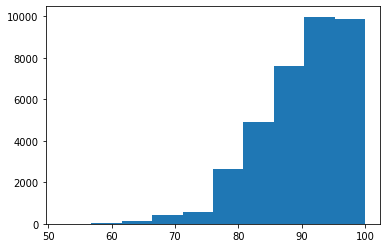

In [81]:
plt.hist(df['calculated_score'], bins = 10);

In [82]:
len(df.loc[df['calculated_score'] >= 80]) / len(df)

0.95388825919885

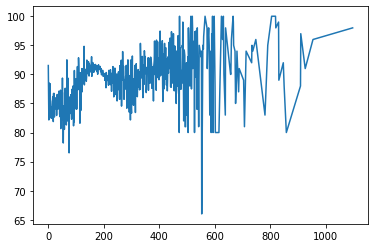

In [99]:
plt.plot(df.groupby(['last_insp_in_days'])['calculated_score'].mean())

In [100]:
df.corr()

,calculated_score,prev_inspection_score,inspection_count,last_insp_in_days
calculated_score,1.000000,0.553788,-0.102742,0.091985
prev_inspection_score,0.553788,1.000000,-0.193022,0.255069
inspection_count,-0.102742,-0.193022,1.000000,-0.398032
last_insp_in_days,0.091985,0.255069,-0.398032,1.000000


In [ ]:
X_text_df['Inspection Score'].groupby(X_text_df['inspection_count']).mean()

In [ ]:
plt.plot(X_text_df['Inspection Score'].groupby(X_text_df['inspection_count']).mean())

In [ ]:
plt.plot(X_text_df['Inspection Score'].groupby(X_text_df['inspection_count']).min())

In [ ]:
df

In [ ]:
# Filter on follow-up only
# Match them with their routine
# put them side by side

# add success metric and models to problem statement
# finish EDA

In [ ]:
# set up target column (essentially a lag of -1, added a new column)
# get modeling done, clean up notebook